***Fundamentals of Solar Cells and Photovoltaic Systems Engineering***

**Solutions Manual - Chapter 2**

***Problem 2.18***

***Using pvlib-python, satellite data from PVGIS, and assuming a PV installation located in Wellington, New Zealand (41°17′20″ S, 174°46′38″ E):***

***(a) Calculate the interannual variability of the daily solar irradiation $G_d(0)$ on March 21***

***(b) Calculate the interannual variability of the monthly mean of the daily solar irradiation $G_{dM}(0)$ on March.***

***(c) Calculate the interannual variability of the annual mean of the daily solar irradiation $G_{dY}(0)$.***

***(d) Discuss the previous results.***


We start by importing several packages that will be useful, including [pandas](https://pandas.pydata.org/) and [matplotlib.pyplot](https://matplotlib.org/stable/index.html) to plot the results.

In [1]:
import requests
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd

We define a function to retrieve data from PVGIS.
More details regarding how to download data from PVGIS using an APi can be found in https://joint-research-centre.ec.europa.eu/pvgis-photovoltaic-geographical-information-system/getting-started-pvgis/api-non-interactive-service_en

In [2]:
def read_radiation_pvgis(raddatabase):
    params = {'lat': lat, 'lon': lon, 'browser': 1, 'outputformat': 'csv', 'raddatabase': raddatabase}
    
    series_file = Path(f'anual_series_{lat}_{lon}_{raddatabase}.csv')
    if not series_file.exists():
        resp_series = requests.get('https://re.jrc.ec.europa.eu/api/v5_2/seriescalc', params=params)
        with open(series_file, 'wb') as f:
            f.write(resp_series.content)
    
    series = pd.read_csv(series_file, 
                         skiprows=8, 
                         index_col='time', 
                         skipfooter=10, 
                         engine='python',
                         parse_dates=True, 
                         infer_datetime_format=True, 
                         date_parser=lambda x: dt.datetime.strptime(x, '%Y%m%d:%H%M'))
    
    series = series.rename({'G(i)': 'ghi'}, axis='columns')
    series['hour'] = series.index.hour
    series['date'] = series.index.date
    
    return series

We start by defining the location and downloading reanalysis data from PVGIS.

In [3]:
lat, lon = -41.29, 174.77 # Wellington, New Zealand
satellite = read_radiation_pvgis(raddatabase='PVGIS-ERA5')

We calculate the irradiation in every day, the value corresponding to March 21, the average daily irradiation in March and the annually-average daily irradiation. 

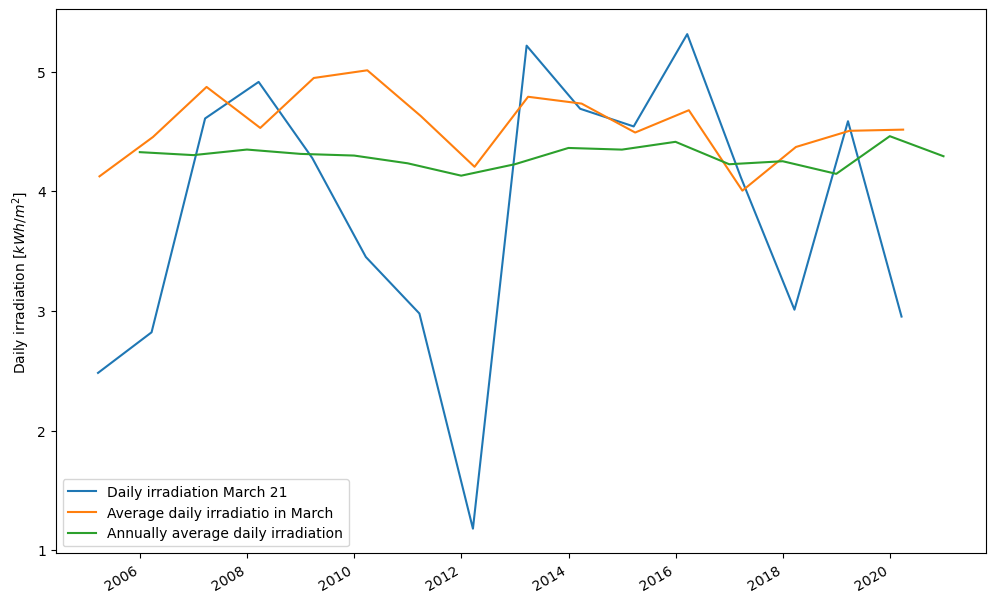

In [4]:
satellite_days = satellite.resample('D').sum(numeric_only=True) /1000 # kWh

# Variability vs time-aggregation
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

satellite_days[satellite_days.index.dayofyear == 80].ghi.plot(ax=ax, label='Daily irradiation March 21') #March 21 corresponds to day 80
satellite_days.resample('M').mean()[satellite_days.resample('M').mean().index.month == 3].ghi.plot(ax=ax, label='Average daily irradiatio in March')
satellite_days.resample('Y').mean().ghi.plot(ax=ax, label='Annually average daily irradiation')
ax.set_ylabel('Daily irradiation [$kWh/m^2$]')
ax.set_xlabel('')
ax.legend()

The analysis of the data shows that (i) there is high interannual variability for the daily irradiation on March 21, hence it is difficult to forecast the output of a PV system on a specific day, (ii) the interannual variability is lower when we look at the average daily irradiation on March, hence it would be easier to forecast the monthly value of irradiation, (iii) finally, the interannual variability of the annually-averaged daily irradiation is significantly smaller indicating that there would be significantly less uncertainty when forecasting annual electricity generation from a PV installation than when trying to forecast the electricity output on a particular date.